In [24]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from utils.readData import read_dataset
from utils.ResNet import ResNet18
import torchvision


In [25]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We down the CIFAR-10 dataset by torchvision.datasets.CIFAR10().

In [26]:
# down CIFAR10 dataset
# torchvision.datasets.CIFAR10(root='dataset',download=True) 

Data augmentation

In [27]:
# read data and arguement
batch_size = 128
train_loader,valid_loader,test_loader = read_dataset(batch_size=batch_size,pic_path='dataset')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Loading and modifying the model. The 7x7 downsampling convolution and maxpooling operation of ResNet18 network is easy to lose information. Here we use a 3x3 downsampling convolution and delete maxpooling operation. This makes the receptive field larger and learns more information.


In [28]:
n_class = 10
model = ResNet18()
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = torch.nn.Linear(512, n_class) 
model = model.to(device)

In [29]:
#Cross-entropy loss function
criterion = nn.CrossEntropyLoss().to(device)

Training the model. We use the SGD optimizer and a dynamic lr. If the loss of the validation set trained after 10 epochs does not decrease, the lr will be halved. The model is trained for 100 epochs.

In [30]:
n_epochs = 100
valid_loss_min = np.Inf # track change in validation loss
accuracy = []
lr = 0.1
counter = 0

trainloss_list = []
validloss_list = []


In [31]:
for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    total_sample = 0
    right_sample = 0
    
    #dynamic lr
    if counter/10 ==1:
        counter = 0
        lr = lr*0.5
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    ###################
    # model from train set#
    ###################
    model.train() 
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data).to(device) 
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Validating models#
    ######################

    model.eval()  
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data).to(device)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        # correct = np.squeeze(correct_tensor.to(device).numpy())
        total_sample += batch_size
        for i in correct_tensor:
            if i:
                right_sample += 1
    print("Accuracy:",100*right_sample/total_sample,"%")
    accuracy.append(right_sample/total_sample)
  
    # Calculate the average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    trainloss_list.append(train_loss)
    validloss_list.append(valid_loss)
        
    # Print loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model when the validation loss decrease
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'checkpoint/resnet18_cifar10.pt')
        valid_loss_min = valid_loss
        counter = 0
    else:
        counter += 1

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 30.043512658227847 %
Epoch: 1 	Training Loss: 2.148593 	Validation Loss: 1.836193
Validation loss decreased (inf --> 1.836193).  Saving model ...


  1%|          | 1/100 [00:36<1:00:59, 36.96s/it]

Accuracy: 39.76463607594937 %
Epoch: 2 	Training Loss: 1.649852 	Validation Loss: 1.627810
Validation loss decreased (1.836193 --> 1.627810).  Saving model ...


  2%|▏         | 2/100 [01:13<59:52, 36.66s/it]  

Accuracy: 47.09256329113924 %
Epoch: 3 	Training Loss: 1.443254 	Validation Loss: 1.442001
Validation loss decreased (1.627810 --> 1.442001).  Saving model ...


  3%|▎         | 3/100 [01:50<59:33, 36.84s/it]

Accuracy: 52.877768987341774 %
Epoch: 4 	Training Loss: 1.285003 	Validation Loss: 1.325661
Validation loss decreased (1.442001 --> 1.325661).  Saving model ...


  4%|▍         | 4/100 [02:27<58:57, 36.84s/it]

Accuracy: 62.11431962025316 %
Epoch: 5 	Training Loss: 1.160895 	Validation Loss: 1.036932
Validation loss decreased (1.325661 --> 1.036932).  Saving model ...


  6%|▌         | 6/100 [03:43<58:49, 37.55s/it]

Accuracy: 55.80498417721519 %
Epoch: 6 	Training Loss: 1.059261 	Validation Loss: 1.306191


  7%|▋         | 7/100 [04:21<58:42, 37.88s/it]

Accuracy: 58.53441455696203 %
Epoch: 7 	Training Loss: 0.975260 	Validation Loss: 1.225534
Accuracy: 71.11352848101266 %
Epoch: 8 	Training Loss: 0.898276 	Validation Loss: 0.799180
Validation loss decreased (1.036932 --> 0.799180).  Saving model ...


  9%|▉         | 9/100 [05:40<58:40, 38.68s/it]

Accuracy: 67.53362341772151 %
Epoch: 9 	Training Loss: 0.838278 	Validation Loss: 0.920938


 10%|█         | 10/100 [06:17<57:17, 38.19s/it]

Accuracy: 70.45094936708861 %
Epoch: 10 	Training Loss: 0.796479 	Validation Loss: 0.872053
Accuracy: 77.79865506329114 %
Epoch: 11 	Training Loss: 0.751958 	Validation Loss: 0.633663
Validation loss decreased (0.799180 --> 0.633663).  Saving model ...


 12%|█▏        | 12/100 [07:35<56:17, 38.39s/it]

Accuracy: 74.4560917721519 %
Epoch: 12 	Training Loss: 0.728342 	Validation Loss: 0.759305


 13%|█▎        | 13/100 [08:11<54:42, 37.73s/it]

Accuracy: 72.66613924050633 %
Epoch: 13 	Training Loss: 0.713302 	Validation Loss: 0.812081


 14%|█▍        | 14/100 [08:47<53:30, 37.33s/it]

Accuracy: 70.7179588607595 %
Epoch: 14 	Training Loss: 0.687236 	Validation Loss: 0.911314
Accuracy: 77.39319620253164 %
Epoch: 15 	Training Loss: 0.667921 	Validation Loss: 0.632683
Validation loss decreased (0.633663 --> 0.632683).  Saving model ...


 16%|█▌        | 16/100 [10:01<51:44, 36.96s/it]

Accuracy: 77.63053797468355 %
Epoch: 16 	Training Loss: 0.655304 	Validation Loss: 0.669986


 17%|█▋        | 17/100 [10:40<52:01, 37.61s/it]

Accuracy: 76.60205696202532 %
Epoch: 17 	Training Loss: 0.642805 	Validation Loss: 0.697406


 18%|█▊        | 18/100 [11:17<51:16, 37.52s/it]

Accuracy: 75.28678797468355 %
Epoch: 18 	Training Loss: 0.633807 	Validation Loss: 0.732751
Accuracy: 81.4873417721519 %
Epoch: 19 	Training Loss: 0.612716 	Validation Loss: 0.523484
Validation loss decreased (0.632683 --> 0.523484).  Saving model ...


 19%|█▉        | 19/100 [11:54<50:28, 37.39s/it]

Accuracy: 81.51700949367088 %
Epoch: 20 	Training Loss: 0.604460 	Validation Loss: 0.508075
Validation loss decreased (0.523484 --> 0.508075).  Saving model ...


 21%|██        | 21/100 [13:10<49:50, 37.85s/it]

Accuracy: 71.88488924050633 %
Epoch: 21 	Training Loss: 0.596858 	Validation Loss: 0.869435


 22%|██▏       | 22/100 [13:48<48:59, 37.68s/it]

Accuracy: 79.9940664556962 %
Epoch: 22 	Training Loss: 0.594250 	Validation Loss: 0.554106


 23%|██▎       | 23/100 [14:27<49:01, 38.21s/it]

Accuracy: 68.93789556962025 %
Epoch: 23 	Training Loss: 0.579619 	Validation Loss: 1.113698


 24%|██▍       | 24/100 [15:07<48:53, 38.60s/it]

Accuracy: 70.63884493670886 %
Epoch: 24 	Training Loss: 0.570117 	Validation Loss: 0.958020


 25%|██▌       | 25/100 [15:46<48:26, 38.76s/it]

Accuracy: 80.3698575949367 %
Epoch: 25 	Training Loss: 0.572584 	Validation Loss: 0.579248


 26%|██▌       | 26/100 [16:23<47:22, 38.41s/it]

Accuracy: 79.62816455696202 %
Epoch: 26 	Training Loss: 0.562501 	Validation Loss: 0.610938
Accuracy: 84.36511075949367 %
Epoch: 27 	Training Loss: 0.559054 	Validation Loss: 0.429594
Validation loss decreased (0.508075 --> 0.429594).  Saving model ...


 28%|██▊       | 28/100 [17:37<45:07, 37.61s/it]

Accuracy: 80.5379746835443 %
Epoch: 28 	Training Loss: 0.553559 	Validation Loss: 0.558965


 29%|██▉       | 29/100 [18:14<44:14, 37.38s/it]

Accuracy: 80.59731012658227 %
Epoch: 29 	Training Loss: 0.548836 	Validation Loss: 0.545946


 30%|███       | 30/100 [18:51<43:21, 37.16s/it]

Accuracy: 82.86194620253164 %
Epoch: 30 	Training Loss: 0.540778 	Validation Loss: 0.481596


 31%|███       | 31/100 [19:27<42:28, 36.93s/it]

Accuracy: 79.88528481012658 %
Epoch: 31 	Training Loss: 0.538540 	Validation Loss: 0.582291


 32%|███▏      | 32/100 [20:03<41:43, 36.81s/it]

Accuracy: 82.05102848101266 %
Epoch: 32 	Training Loss: 0.534667 	Validation Loss: 0.521068


 33%|███▎      | 33/100 [20:40<41:05, 36.80s/it]

Accuracy: 73.79351265822785 %
Epoch: 33 	Training Loss: 0.526793 	Validation Loss: 0.780165


 34%|███▍      | 34/100 [21:17<40:23, 36.72s/it]

Accuracy: 79.77650316455696 %
Epoch: 34 	Training Loss: 0.533215 	Validation Loss: 0.574928


 35%|███▌      | 35/100 [21:53<39:42, 36.66s/it]

Accuracy: 82.02136075949367 %
Epoch: 35 	Training Loss: 0.534532 	Validation Loss: 0.514805


 36%|███▌      | 36/100 [22:30<39:03, 36.61s/it]

Accuracy: 80.1621835443038 %
Epoch: 36 	Training Loss: 0.518865 	Validation Loss: 0.574628
Accuracy: 84.86946202531645 %
Epoch: 37 	Training Loss: 0.520540 	Validation Loss: 0.417550
Validation loss decreased (0.429594 --> 0.417550).  Saving model ...


 38%|███▊      | 38/100 [23:42<37:35, 36.38s/it]

Accuracy: 82.21914556962025 %
Epoch: 38 	Training Loss: 0.524235 	Validation Loss: 0.495757


 39%|███▉      | 39/100 [24:18<36:54, 36.30s/it]

Accuracy: 82.44659810126582 %
Epoch: 39 	Training Loss: 0.518707 	Validation Loss: 0.501670


 40%|████      | 40/100 [24:54<36:12, 36.20s/it]

Accuracy: 78.13488924050633 %
Epoch: 40 	Training Loss: 0.523683 	Validation Loss: 0.657837


 41%|████      | 41/100 [25:31<35:42, 36.31s/it]

Accuracy: 82.49604430379746 %
Epoch: 41 	Training Loss: 0.520800 	Validation Loss: 0.483794


 42%|████▏     | 42/100 [26:07<35:07, 36.34s/it]

Accuracy: 83.31685126582279 %
Epoch: 42 	Training Loss: 0.502332 	Validation Loss: 0.470932


 43%|████▎     | 43/100 [26:44<34:37, 36.45s/it]

Accuracy: 81.35878164556962 %
Epoch: 43 	Training Loss: 0.510550 	Validation Loss: 0.561645


 44%|████▍     | 44/100 [27:20<34:02, 36.47s/it]

Accuracy: 81.64556962025317 %
Epoch: 44 	Training Loss: 0.505780 	Validation Loss: 0.523922


 45%|████▌     | 45/100 [27:57<33:23, 36.43s/it]

Accuracy: 78.21400316455696 %
Epoch: 45 	Training Loss: 0.503534 	Validation Loss: 0.649474


 46%|████▌     | 46/100 [28:33<32:50, 36.48s/it]

Accuracy: 81.95213607594937 %
Epoch: 46 	Training Loss: 0.506658 	Validation Loss: 0.514182


 47%|████▋     | 47/100 [29:10<32:15, 36.52s/it]

Accuracy: 77.7195411392405 %
Epoch: 47 	Training Loss: 0.501318 	Validation Loss: 0.708908
Accuracy: 86.3429588607595 %
Epoch: 48 	Training Loss: 0.383435 	Validation Loss: 0.387479
Validation loss decreased (0.417550 --> 0.387479).  Saving model ...


 48%|████▊     | 48/100 [29:49<32:14, 37.20s/it]

Accuracy: 88.64715189873418 %
Epoch: 49 	Training Loss: 0.356928 	Validation Loss: 0.319311
Validation loss decreased (0.387479 --> 0.319311).  Saving model ...


 49%|████▉     | 49/100 [30:27<31:54, 37.53s/it]

Accuracy: 88.49881329113924 %
Epoch: 50 	Training Loss: 0.359976 	Validation Loss: 0.313474
Validation loss decreased (0.319311 --> 0.313474).  Saving model ...


 51%|█████     | 51/100 [31:41<30:27, 37.29s/it]

Accuracy: 86.47151898734177 %
Epoch: 51 	Training Loss: 0.366304 	Validation Loss: 0.370225


 52%|█████▏    | 52/100 [32:18<29:43, 37.16s/it]

Accuracy: 86.21439873417721 %
Epoch: 52 	Training Loss: 0.365406 	Validation Loss: 0.371662
Accuracy: 89.00316455696202 %
Epoch: 53 	Training Loss: 0.365927 	Validation Loss: 0.295336
Validation loss decreased (0.313474 --> 0.295336).  Saving model ...


 54%|█████▍    | 54/100 [33:32<28:30, 37.18s/it]

Accuracy: 86.08583860759494 %
Epoch: 54 	Training Loss: 0.366973 	Validation Loss: 0.392944


 55%|█████▌    | 55/100 [34:09<27:42, 36.93s/it]

Accuracy: 87.79667721518987 %
Epoch: 55 	Training Loss: 0.363699 	Validation Loss: 0.325730


 56%|█████▌    | 56/100 [34:47<27:25, 37.41s/it]

Accuracy: 87.82634493670886 %
Epoch: 56 	Training Loss: 0.373367 	Validation Loss: 0.337313


 57%|█████▋    | 57/100 [35:26<27:01, 37.72s/it]

Accuracy: 87.34177215189874 %
Epoch: 57 	Training Loss: 0.369950 	Validation Loss: 0.369354


 58%|█████▊    | 58/100 [36:02<26:09, 37.38s/it]

Accuracy: 85.03757911392405 %
Epoch: 58 	Training Loss: 0.359753 	Validation Loss: 0.420731


 59%|█████▉    | 59/100 [36:41<25:50, 37.81s/it]

Accuracy: 88.13291139240506 %
Epoch: 59 	Training Loss: 0.368076 	Validation Loss: 0.323496


 60%|██████    | 60/100 [37:19<25:11, 37.78s/it]

Accuracy: 87.94501582278481 %
Epoch: 60 	Training Loss: 0.357933 	Validation Loss: 0.318446


 61%|██████    | 61/100 [37:58<24:50, 38.21s/it]

Accuracy: 84.10799050632912 %
Epoch: 61 	Training Loss: 0.366273 	Validation Loss: 0.464579


 62%|██████▏   | 62/100 [38:37<24:16, 38.32s/it]

Accuracy: 87.41099683544304 %
Epoch: 62 	Training Loss: 0.371694 	Validation Loss: 0.357022


 63%|██████▎   | 63/100 [39:13<23:17, 37.78s/it]

Accuracy: 88.17246835443038 %
Epoch: 63 	Training Loss: 0.362785 	Validation Loss: 0.323303
Accuracy: 91.27768987341773 %
Epoch: 64 	Training Loss: 0.262625 	Validation Loss: 0.219763
Validation loss decreased (0.295336 --> 0.219763).  Saving model ...


 65%|██████▌   | 65/100 [40:26<21:41, 37.19s/it]

Accuracy: 91.17879746835443 %
Epoch: 65 	Training Loss: 0.243971 	Validation Loss: 0.235017


 66%|██████▌   | 66/100 [41:06<21:25, 37.82s/it]

Accuracy: 91.3370253164557 %
Epoch: 66 	Training Loss: 0.247485 	Validation Loss: 0.222872


 67%|██████▋   | 67/100 [41:45<21:00, 38.21s/it]

Accuracy: 91.46558544303798 %
Epoch: 67 	Training Loss: 0.240794 	Validation Loss: 0.231592


 68%|██████▊   | 68/100 [42:22<20:14, 37.97s/it]

Accuracy: 90.50632911392405 %
Epoch: 68 	Training Loss: 0.238459 	Validation Loss: 0.255109


 69%|██████▉   | 69/100 [42:58<19:18, 37.35s/it]

Accuracy: 90.70411392405063 %
Epoch: 69 	Training Loss: 0.242071 	Validation Loss: 0.254273
Accuracy: 91.94026898734177 %
Epoch: 70 	Training Loss: 0.237941 	Validation Loss: 0.202736
Validation loss decreased (0.219763 --> 0.202736).  Saving model ...


 71%|███████   | 71/100 [44:11<17:52, 37.00s/it]

Accuracy: 90.78322784810126 %
Epoch: 71 	Training Loss: 0.246076 	Validation Loss: 0.251875


 72%|███████▏  | 72/100 [44:47<17:06, 36.68s/it]

Accuracy: 90.57555379746836 %
Epoch: 72 	Training Loss: 0.247964 	Validation Loss: 0.257359


 73%|███████▎  | 73/100 [45:23<16:25, 36.49s/it]

Accuracy: 90.65466772151899 %
Epoch: 73 	Training Loss: 0.246448 	Validation Loss: 0.253000


 74%|███████▍  | 74/100 [45:59<15:44, 36.32s/it]

Accuracy: 91.0007911392405 %
Epoch: 74 	Training Loss: 0.249183 	Validation Loss: 0.250658


 75%|███████▌  | 75/100 [46:36<15:10, 36.43s/it]

Accuracy: 91.0007911392405 %
Epoch: 75 	Training Loss: 0.246847 	Validation Loss: 0.242367


 76%|███████▌  | 76/100 [47:12<14:32, 36.37s/it]

Accuracy: 90.90189873417721 %
Epoch: 76 	Training Loss: 0.244605 	Validation Loss: 0.244885


 77%|███████▋  | 77/100 [47:48<13:54, 36.29s/it]

Accuracy: 90.17009493670886 %
Epoch: 77 	Training Loss: 0.247707 	Validation Loss: 0.253833


 78%|███████▊  | 78/100 [48:24<13:16, 36.19s/it]

Accuracy: 90.98101265822785 %
Epoch: 78 	Training Loss: 0.242977 	Validation Loss: 0.238221


 79%|███████▉  | 79/100 [49:01<12:41, 36.24s/it]

Accuracy: 89.78441455696202 %
Epoch: 79 	Training Loss: 0.245449 	Validation Loss: 0.295868


 80%|████████  | 80/100 [49:37<12:07, 36.37s/it]

Accuracy: 90.32832278481013 %
Epoch: 80 	Training Loss: 0.241570 	Validation Loss: 0.261126
Accuracy: 92.95886075949367 %
Epoch: 81 	Training Loss: 0.178194 	Validation Loss: 0.181792
Validation loss decreased (0.202736 --> 0.181792).  Saving model ...


 81%|████████  | 81/100 [50:14<11:34, 36.55s/it]

Accuracy: 93.23575949367088 %
Epoch: 82 	Training Loss: 0.156351 	Validation Loss: 0.171107
Validation loss decreased (0.181792 --> 0.171107).  Saving model ...


 83%|████████▎ | 83/100 [51:27<10:21, 36.54s/it]

Accuracy: 92.4940664556962 %
Epoch: 83 	Training Loss: 0.155772 	Validation Loss: 0.198652


 84%|████████▍ | 84/100 [52:04<09:44, 36.54s/it]

Accuracy: 93.2753164556962 %
Epoch: 84 	Training Loss: 0.158871 	Validation Loss: 0.179463


 85%|████████▌ | 85/100 [52:40<09:05, 36.36s/it]

Accuracy: 92.5929588607595 %
Epoch: 85 	Training Loss: 0.150386 	Validation Loss: 0.197031


 86%|████████▌ | 86/100 [53:16<08:28, 36.33s/it]

Accuracy: 92.48417721518987 %
Epoch: 86 	Training Loss: 0.151803 	Validation Loss: 0.192303


 87%|████████▋ | 87/100 [53:53<07:52, 36.33s/it]

Accuracy: 93.33465189873418 %
Epoch: 87 	Training Loss: 0.149417 	Validation Loss: 0.172061


 88%|████████▊ | 88/100 [54:29<07:16, 36.40s/it]

Accuracy: 92.41495253164557 %
Epoch: 88 	Training Loss: 0.148384 	Validation Loss: 0.203027


 89%|████████▉ | 89/100 [55:05<06:39, 36.36s/it]

Accuracy: 92.94897151898734 %
Epoch: 89 	Training Loss: 0.144414 	Validation Loss: 0.181817


 90%|█████████ | 90/100 [55:42<06:03, 36.30s/it]

Accuracy: 93.15664556962025 %
Epoch: 90 	Training Loss: 0.151795 	Validation Loss: 0.185086


 91%|█████████ | 91/100 [56:18<05:26, 36.26s/it]

Accuracy: 92.61273734177215 %
Epoch: 91 	Training Loss: 0.153076 	Validation Loss: 0.196002


 92%|█████████▏| 92/100 [56:54<04:49, 36.18s/it]

Accuracy: 92.74129746835443 %
Epoch: 92 	Training Loss: 0.151387 	Validation Loss: 0.197884
Accuracy: 94.00712025316456 %
Epoch: 93 	Training Loss: 0.113192 	Validation Loss: 0.155822
Validation loss decreased (0.171107 --> 0.155822).  Saving model ...


 94%|█████████▍| 94/100 [58:06<03:37, 36.29s/it]

Accuracy: 94.06645569620254 %
Epoch: 94 	Training Loss: 0.102553 	Validation Loss: 0.158883
Accuracy: 94.20490506329114 %
Epoch: 95 	Training Loss: 0.099074 	Validation Loss: 0.153291
Validation loss decreased (0.155822 --> 0.153291).  Saving model ...


 96%|█████████▌| 96/100 [59:19<02:25, 36.38s/it]

Accuracy: 93.75988924050633 %
Epoch: 96 	Training Loss: 0.093650 	Validation Loss: 0.165284


 97%|█████████▋| 97/100 [59:56<01:49, 36.53s/it]

Accuracy: 93.87856012658227 %
Epoch: 97 	Training Loss: 0.090895 	Validation Loss: 0.160520


 98%|█████████▊| 98/100 [1:00:33<01:13, 36.52s/it]

Accuracy: 93.73022151898734 %
Epoch: 98 	Training Loss: 0.091035 	Validation Loss: 0.169060


 99%|█████████▉| 99/100 [1:01:09<00:36, 36.50s/it]

Accuracy: 94.07634493670886 %
Epoch: 99 	Training Loss: 0.089447 	Validation Loss: 0.160310


100%|██████████| 100/100 [1:01:46<00:00, 37.07s/it]

Accuracy: 93.8192246835443 %
Epoch: 100 	Training Loss: 0.088318 	Validation Loss: 0.165845


In [32]:
#Print best accuray
print("Best Accuracy:", 100 * max(accuracy), "%")


Best Accuracy: 94.20490506329115 %


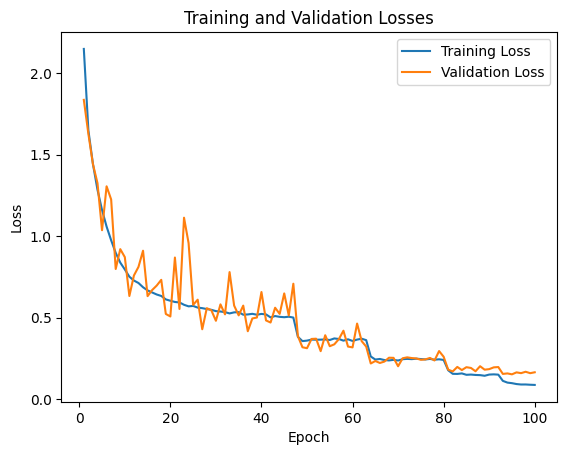

In [33]:
# Plotting the training and validation losses
import matplotlib.pyplot as plt

plt.plot(range(1, n_epochs+1), trainloss_list, label='Training Loss')
plt.plot(range(1, n_epochs+1), validloss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [34]:
# Model size 11173962
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)


Total number of parameters:  11173962
